In [1]:
# Solving burgers' equation with forward finite difference in time,
# and central difference in space.
# u_t + u * u_x = 0
# u_t + ((u**2)/2)_x = 0
# u_t = -1/2 * d(u**2)/dx

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib nbagg

In [3]:
def simulate(end_time, timesteps, xs, initial, left, right):
    space_steps = len(initial)
    dt = end_time / timesteps
    results = np.zeros((timesteps, space_steps))
    results[0] = initial
    # TODO: kinda jank but I guess its actually ok
    dxs = np.array([xs[i] - xs[i - 1] for i in range(1, space_steps)])
    dxs = np.array([xs[i] - xs[i - 2] for i in range(2, space_steps)])
    k = dt / 2
    for i in range(1, timesteps):
        left_u = results[i-1, :-2]
        right_u = results[i-1, 2:]
        results[i, 1:space_steps - 1] = (left_u + right_u) / 2 + k * (left_u**2 - right_u**2) / dxs
#         for j in range(1, space_steps - 1):
#             left_u = results[i-1, j-1]
#             right_u = results[i-1, j+1]
#             results[i, j] = (left_u + right_u) / 2 + dt * (left_u**2 - right_u**2) / (4 * dxs[j - 1])
        results[i, 0] = left(dt * i)
        results[i, -1] = right(dt * i)
    return results

In [4]:
def const_zero(x):
    return 0

def const_one(x):
    return 1

def initial_piecewise(steps):
    xs = np.linspace(-1, 3, num=steps)
    ys = np.zeros(steps)
    i = 0
    while i < steps and xs[i] < 0:
        ys[i] = 1
        i += 1
    while i < steps and xs[i] < 1:
        ys[i] = 1 - xs[i]
        i += 1
    return 4 / steps, xs, ys

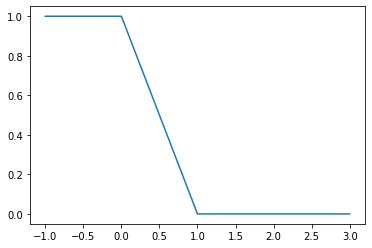

In [5]:
dx, xs, ys = initial_piecewise(1200)
plt.plot(xs, ys)

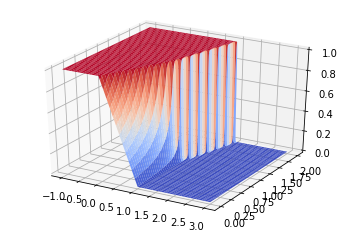

In [6]:
t_steps = 800
end_t = 2
results = simulate(end_t, t_steps, xs, ys, const_one, const_zero)
ts = np.linspace(0, end_t, num=t_steps)
X, Y = np.meshgrid(xs, ts)
hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(X, Y, results, cmap=cm.coolwarm)

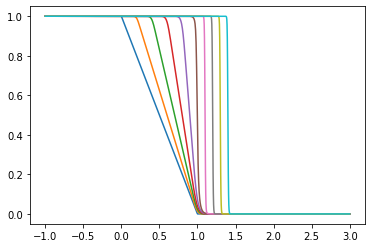

In [7]:
t_substeps = 10
t_substep = t_steps // t_substeps
plt.figure()
for i in range(t_substeps):
    plt.plot(xs, results[t_substep * i])
plt.show()

In [8]:
def initial_cos(steps):
    xs = np.linspace(-np.pi / 2, 1.5 * np.pi, num=steps)
    ys = np.cos(xs) * (xs < np.pi / 2)
    return 2 * np.pi / steps, xs, ys

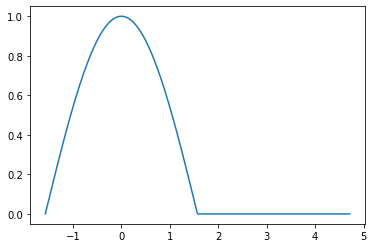

In [9]:
dx, xs, ys = initial_cos(600)
plt.plot(xs, ys)
plt.show()

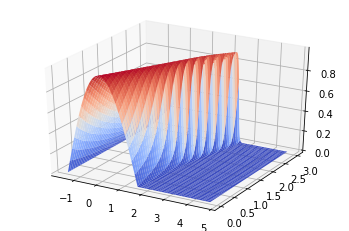

In [10]:
t_steps = 800
end_t = 3
results = simulate(end_t, t_steps, xs, ys, const_zero, const_zero)
ts = np.linspace(0, end_t, num=t_steps)
X, Y = np.meshgrid(xs, ts)
hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(X, Y, results, cmap=cm.coolwarm)

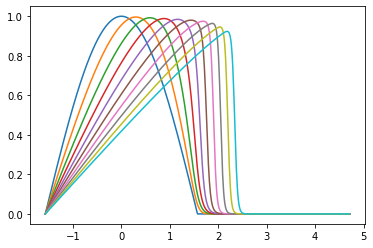

In [11]:
t_substeps = 10
t_substep = t_steps // t_substeps
plt.figure()
for i in range(t_substeps):
    plt.plot(xs, results[t_substep * i])
plt.show()

In [12]:
import random

def random_poly(order, coef_stdev):
    if (order == 0):
        return (lambda x: 1)
    if (order == 1):
        return (lambda x: 1 - x)
    prev = random_poly(order - 1, coef_stdev)
    k = random.gauss(0, coef_stdev / np.sqrt(order))
    return (lambda x: (1 + k*x) * prev(x))

def random_poly_flip(order, coef_stdev):
    if (order == 0):
        return (lambda x: 1)
    if (order == 1):
        return (lambda x: x)
    prev = random_poly_flip(order - 1, coef_stdev)
    k = random.gauss(0, coef_stdev / np.sqrt(order))
    return (lambda x: (1 + k * (1 - x)) * prev(x))

def piecewise_random_split(xs, max_splits, max_degree, coef_stdev, jump_chance):
    num_splits = random.randint(0, max_splits)
    return piecewise_random_poly(xs, num_splits, max_degree, coef_stdev, jump_chance)
    
def piecewise_random_poly(xs, num_splits, max_degree, coef_stdev, jump_chance):
    split_locs = np.random.choice(len(xs) - 2, size=num_splits, replace=False)
    split_locs.sort()
    split_locs = list(split_locs)
    split_locs.append(len(xs) - 1)
    
    i0 = 0
    start_y = random.gauss(0, coef_stdev)
    
    ys = np.zeros(len(xs))
    
    for i1 in split_locs:
        poly_degree = random.randint(0, max_degree)
        inputs = np.linspace(0, 1, num=i1-i0+1)
        if random.random() < 0.5:
            poly = random_poly_flip(poly_degree, coef_stdev)
            ys[i0:i1 + 1] = start_y + random.gauss(0, coef_stdev) * poly(inputs)
        else:
            poly = random_poly(poly_degree, coef_stdev)
            scaling = random.gauss(0, coef_stdev)
            ys[i0:i1 + 1] = start_y + scaling * (poly(inputs) - 1)
        
        i0 = i1
        if random.random() < jump_chance:
            start_y = random.gauss(0, coef_stdev)
        elif i1 < len(xs):
            start_y = ys[i1]
    return ys

def const_x(x):
    return (lambda _: x)

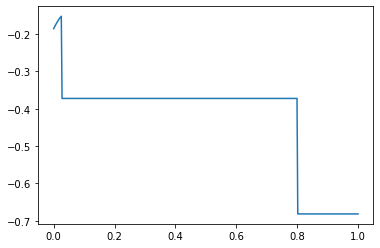

In [15]:
xs = np.linspace(0, 1, num=400)
ys = piecewise_random_poly(xs, 2, 5, 0.5, 0.25)
plt.plot(xs, ys)

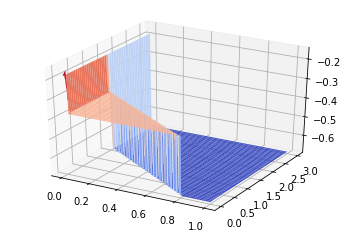

In [16]:
t_steps = 800
end_t = 3
results = simulate(end_t, t_steps, xs, ys, lambda x: ys[0], lambda x: ys[-1])
ts = np.linspace(0, end_t, num=t_steps)
X, Y = np.meshgrid(xs, ts)
hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(X, Y, results, cmap=cm.coolwarm)

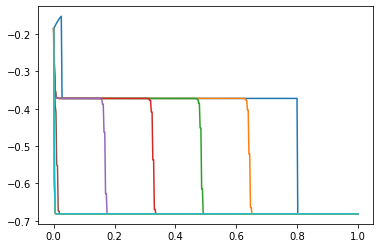

In [17]:
t_substeps = 10
t_substep = t_steps // t_substeps
plt.figure()
for i in range(t_substeps):
    plt.plot(xs, results[t_substep * i])
plt.show()

In [6]:
def run_many_and_save(num_runs, dest_file, save_full=False):
    xs = np.linspace(0, 1, num=400)
    t_steps = 800
    end_t = 3
    results_list = []
    successes = 0
    for i in range(num_runs):
        if i % 100 == 0:
            print("Running simulation number ", i)
        ys = piecewise_random_poly(xs, 2, 5, 0.5, 0.25)
        results = simulate(end_t, t_steps, xs, ys, lambda x: ys[0], lambda x: ys[-1])
        success = np.isfinite(results).all()
        successes += success
        if (save_full):
            results_list.append((results[0], results, success))
        else:
            results_list.append((results[0], success))
    results_array = np.array(results_list)
    np.save(dest_file, results_array)    
    print("done!")
    print("Successes: {}, runs: {}".format(successes, num_runs))
    return results_array

In [7]:
# all_results = run_many_and_save(1000, "out.npy", save_full=True)

In [ ]:
training_results = run_many_and_save(50000, "burgers.npy")

Running simulation number  0


/usr/lib/python3/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in square
  del sys.path[0]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in subtract
  del sys.path[0]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in add
  del sys.path[0]


Running simulation number  100
Running simulation number  200
Running simulation number  300
Running simulation number  400
Running simulation number  500
Running simulation number  600
Running simulation number  700
Running simulation number  800
Running simulation number  900
Running simulation number  1000
Running simulation number  1100
Running simulation number  1200
Running simulation number  1300
Running simulation number  1400
Running simulation number  1500
Running simulation number  1600
Running simulation number  1700
Running simulation number  1800
Running simulation number  1900
Running simulation number  2000
Running simulation number  2100
Running simulation number  2200
Running simulation number  2300
Running simulation number  2400
Running simulation number  2500
Running simulation number  2600
Running simulation number  2700
Running simulation number  2800
Running simulation number  2900
Running simulation number  3000
Running simulation number  3100
Running simulatio

In [ ]:
print(training_results[:10])

In [ ]:
xs = np.linspace(0, 1, num=400)
for i in range(10):
    plt.figure()
    plt.plot(xs, training_results[i][0])
    print(training_results[i][1])